## 0) Setup & Configuration

In [1]:
"""
This script sets up the configuration and paths for training a Fully conected neural network classifier 
using embeddings generated from audio files. The dataset used is specific to the "chiffchaff" bird 
species, and the script supports one type of data splits: "withinyear". 

Key functionalities:
- Sets random seed for reproducibility using the `lightning` library.
- Defines paths for dataset parts and metadata CSVs based on the split type.
- Configures logging directories for TensorBoard.
- Specifies model hyperparameters such as embedding dimension, hidden dimension, and learning rate.

Variables:
- DATASET_NAME: Name of the dataset being used (e.g., "chiffchaff").
- SPLIT_TYPE: Type of data split ("withinyear" or "acrossyear").
- PARTS_DIR: Directory containing Parquet files with embeddings.
- TRN_CSV, TST_CSV: Paths to training and testing metadata CSVs.
- LABEL_KEY_COL: Column name in the label CSVs containing filenames.
- EMB_KEY_COL: Column name in the Parquet files containing filenames.
- LIMIT_N_PARTS: Optional limit on the number of Parquet parts to use (0 = use all).
- LOG_ROOT, LOG_DIR: Directories for storing TensorBoard logs.
- RUN_NAME: Name of the current run for logging purposes.
- EMBEDDING_DIM: Dimensionality of the input embeddings.
- HIDDEN_DIM: Dimensionality of the FCNN's hidden layer.
- LEARNING_RATE: Learning rate for the model optimizer.

Note:
Ensure that the paths specified for the dataset and metadata files exist and are accessible 
before running the script. Modify the `SPLIT_TYPE` variable to switch between "withinyear" 
and "acrossyear" splits.
"""

from lightning import seed_everything

seed_everything(23, workers=True)

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ---- Dataset config ----
DATASET_NAME = "chiffchaff"
SPLIT_TYPE   = "withinyear"  #"withinyear  or "acrossyear"

# Parquet parts produced by your embedding notebook
PARTS_DIR = Path("/teamspace/studios/stowell-data-birdnetlib/Output_files/Embeddings_from_3sPadding") / f"{DATASET_NAME}_parquet_parts"

# Within-year one-hot label CSVs (train + test)
if SPLIT_TYPE == "withinyear": 
    TRN_CSV = Path("/teamspace/studios/stowell-data-birdnetlib/Output_metadata/chiffchaff-fg/chiffchaff-withinyear-fg-trn.csv")
    TST_CSV = Path("/teamspace/studios/stowell-data-birdnetlib/Output_metadata/chiffchaff-fg/chiffchaff-withinyear-fg-tst.csv")
elif SPLIT_TYPE == "acrossyear":
    TRN_CSV = Path("/teamspace/studios/stowell-data-birdnetlib/Output_metadata/chiffchaff-fg/chiffchaff-acrossyear-fg-trn.csv")
    TST_CSV = Path("/teamspace/studios/stowell-data-birdnetlib/Output_metadata/chiffchaff-fg/chiffchaff-acrossyear-fg-tst.csv")
else:
    raise ValueError(f"Unknown split type: {SPLIT_TYPE}")

# Column with filenames in label CSVs
LABEL_KEY_COL = "wavfilename"

# Name of the filename column in your Parquet outputs
EMB_KEY_COL = "file_name"

# Optional quick subset of parts (0 = use all)
LIMIT_N_PARTS = 0


# Logging layout: logs/<DATASET_NAME>/<SPLIT_TYPE>/<RUN_NAME>
PARENT_DIR = Path.cwd().parent
LOG_ROOT = PARENT_DIR / "logs_FCN_birdnet_pooling"
RUN_NAME = f"{DATASET_NAME}_{SPLIT_TYPE}_FCN"
LOG_DIR  = LOG_ROOT / DATASET_NAME / SPLIT_TYPE
LOG_DIR.mkdir(parents=True, exist_ok=True)

print("TensorBoard logs will go to:", LOG_DIR / RUN_NAME)

# ---- Model hyperparameters ----
EMBEDDING_DIM = 1024
HIDDEN_DIM = 256
LEARNING_RATE = 1e-3

Seed set to 23


TensorBoard logs will go to: /teamspace/studios/this_studio/logs_FCN_birdnet_pooling/chiffchaff/withinyear/chiffchaff_withinyear_FCN


## 1) Load and combine labels (one-hot → single label per file)

In [2]:
from pathlib import Path
import pandas as pd

# ---- Load available CSVs (train required, test optional) ----
csv_paths = []
if 'TRN_CSV' in locals() and TRN_CSV is not None and Path(TRN_CSV).exists():
    csv_paths.append(TRN_CSV)
if 'TST_CSV' in locals() and TST_CSV is not None and Path(TST_CSV).exists():
    csv_paths.append(TST_CSV)

if not csv_paths:
    raise ValueError("No label CSVs found. Provide at least TRN_CSV.")

dfs = [pd.read_csv(p) for p in csv_paths]
combined_df = pd.concat(dfs, ignore_index=True)

# ---- Choose schema: single-label vs one-hot ----

# Case A: single label column present (e.g., 'class')
SINGLE_LABEL_COLS = [c for c in ["class", "label", "individual_id"] if c in combined_df.columns]

if SINGLE_LABEL_COLS:
    LABEL_VALUE_COL = SINGLE_LABEL_COLS[0]  # pick the first available
    # Build label column directly
    combined_df["label"] = combined_df[LABEL_VALUE_COL].astype(str)

    # Normalize filenames for robust matching with embeddings
    if LABEL_KEY_COL not in combined_df.columns:
        raise ValueError(f"Missing filename column '{LABEL_KEY_COL}' in label CSV(s).")
    combined_df[LABEL_KEY_COL] = combined_df[LABEL_KEY_COL].astype(str).str.lower()

    combined_labels_dict = dict(zip(combined_df[LABEL_KEY_COL], combined_df["label"]))
    label_keys = set(combined_labels_dict.keys())

    print(f"[Single-label schema] Using '{LABEL_VALUE_COL}' as labels.")
    print(f"Loaded {len(combined_df):,} label rows; unique labeled audio files: {len(label_keys):,}")
    print("Example mapping:", list(combined_labels_dict.items())[:3])

else:
    # Case B: one-hot schema 
    if LABEL_KEY_COL not in combined_df.columns:
        raise ValueError(f"Missing filename column '{LABEL_KEY_COL}' in label CSV(s).")

    indiv_cols = [c for c in combined_df.columns if c != LABEL_KEY_COL]
    if not indiv_cols:
        raise ValueError("No one-hot individual columns found in the labels CSVs.")

    row_sums = combined_df[indiv_cols].sum(axis=1)
    if (row_sums == 0).all():
        raise ValueError("All rows in the one-hot block are zeros; no labeled files detected.")

    # One-hot → single string label: the column name containing the 1
    combined_df["label"] = combined_df[indiv_cols].idxmax(axis=1)

    # Normalize filenames
    combined_df[LABEL_KEY_COL] = combined_df[LABEL_KEY_COL].astype(str).str.lower()

    combined_labels_dict = dict(zip(combined_df[LABEL_KEY_COL], combined_df["label"]))
    label_keys = set(combined_labels_dict.keys())

    print(f"[One-hot schema] Derived labels from one-hot columns (n={len(indiv_cols)}).")
    print(f"Loaded {len(combined_df):,} label rows; unique labeled audio files: {len(label_keys):,}")
    print("Example mapping:", list(combined_labels_dict.items())[:3])


[One-hot schema] Derived labels from one-hot columns (n=13).
Loaded 6,238 label rows; unique labeled audio files: 6,238
Example mapping: [('cutted_day1_pc1101_0000.wav', 'PC1101'), ('cutted_day1_pc1101_0001.wav', 'PC1101'), ('cutted_day1_pc1101_0002.wav', 'PC1101')]


## 2) Read embeddings from Parquet parts and keep only labeled files

This loads one part at a time to keep memory usage reasonable.

In [3]:
# Find Parquet parts
parts = sorted(PARTS_DIR.glob("part_*.parquet"))
if LIMIT_N_PARTS > 0:
    parts = parts[:LIMIT_N_PARTS]

if not parts:
    raise FileNotFoundError(f"No parquet parts found in: {PARTS_DIR}")

print(f"Found {len(parts)} parquet parts; first 3:", [p.name for p in parts[:3]])

# Build a single DataFrame of labeled embeddings 
# Note: we drop a 'path' column only if it exists in the Parquet schema.
kept_chunks = []
for part in parts:
    df_part = pd.read_parquet(part)

    # Normalize filename column for matching
    if EMB_KEY_COL not in df_part.columns:
        raise ValueError(f"Parquet part {part.name} missing column '{EMB_KEY_COL}'")

    df_part[EMB_KEY_COL] = df_part[EMB_KEY_COL].astype(str).str.lower()

    # Filter to labeled files only
    df_part = df_part[df_part[EMB_KEY_COL].isin(label_keys)]
    if df_part.empty:
        continue

    # Drop 'path' if present (your Parquet may not have it)
    if "path" in df_part.columns:
        df_part = df_part.drop(columns=["path"])

    kept_chunks.append(df_part)

# Concatenate all kept rows
if kept_chunks:
    trainvaltest_df = pd.concat(kept_chunks, ignore_index=True)
else:
    trainvaltest_df = pd.DataFrame()
    print("Warning: No embeddings matched the labeled filenames.")

#trainvaltest_df=trainvaltest_df[trainvaltest_df['start_time']==0.0]

trainvaltest_df["label"] = trainvaltest_df[EMB_KEY_COL].map(combined_labels_dict)
cols_to_group = [EMB_KEY_COL, "label"] # Asegúrate que 'label' es el nombre real de tu columna de clases
# Aplicamos el Global Average Pooling
trainvaltest_df = trainvaltest_df.groupby(cols_to_group).mean(numeric_only=True).reset_index()

# Opcional: Limpiar columnas de tiempo sobrantes
cols_to_drop = [c for c in ['start_time', 'end_time'] if c in trainvaltest_df.columns]
if cols_to_drop:
    trainvaltest_df = trainvaltest_df.drop(columns=cols_to_drop)

print(f"Total rows after POOLING (one per file): {len(trainvaltest_df):,}")
print("Columnas finales:", trainvaltest_df.columns.tolist())

print(f"Total kept rows after filtering by labels: {len(trainvaltest_df):,}")



Found 7 parquet parts; first 3: ['part_0000.parquet', 'part_0001.parquet', 'part_0002.parquet']
Total rows after POOLING (one per file): 6,238
Columnas finales: ['file_name', 'label', 'dim_1', 'dim_2', 'dim_3', 'dim_4', 'dim_5', 'dim_6', 'dim_7', 'dim_8', 'dim_9', 'dim_10', 'dim_11', 'dim_12', 'dim_13', 'dim_14', 'dim_15', 'dim_16', 'dim_17', 'dim_18', 'dim_19', 'dim_20', 'dim_21', 'dim_22', 'dim_23', 'dim_24', 'dim_25', 'dim_26', 'dim_27', 'dim_28', 'dim_29', 'dim_30', 'dim_31', 'dim_32', 'dim_33', 'dim_34', 'dim_35', 'dim_36', 'dim_37', 'dim_38', 'dim_39', 'dim_40', 'dim_41', 'dim_42', 'dim_43', 'dim_44', 'dim_45', 'dim_46', 'dim_47', 'dim_48', 'dim_49', 'dim_50', 'dim_51', 'dim_52', 'dim_53', 'dim_54', 'dim_55', 'dim_56', 'dim_57', 'dim_58', 'dim_59', 'dim_60', 'dim_61', 'dim_62', 'dim_63', 'dim_64', 'dim_65', 'dim_66', 'dim_67', 'dim_68', 'dim_69', 'dim_70', 'dim_71', 'dim_72', 'dim_73', 'dim_74', 'dim_75', 'dim_76', 'dim_77', 'dim_78', 'dim_79', 'dim_80', 'dim_81', 'dim_82', 'dim_

## 3) Attach the label to each embedding row

In [4]:
# Map file_name → label
trainvaltest_df["label"] = trainvaltest_df[EMB_KEY_COL].map(combined_labels_dict)

# (Optional) sanity: any missing labels after mapping?
missing = trainvaltest_df["label"].isna().sum()
if missing:
    print(f"Warning: {missing} rows had missing labels after mapping.")


## 4) Stratified split by file (train/val/test)

First split 80/20, then split the 80 into 60/20.

In [5]:
# Unique file-level table (one row per file with its label)
file_labels = trainvaltest_df[[EMB_KEY_COL, "label"]].drop_duplicates()

# 1) 80/20 split (train+val / test)
train_val_files_only, test_files_only = train_test_split(
    file_labels,
    test_size=0.20,
    stratify=file_labels["label"],
    random_state=42,
)

# 2) Split the 80 into 60/20 (train / val)
train_files_only, val_files_only = train_test_split(
    train_val_files_only,
    test_size=0.25,  # 25% of 80% → 20% total
    stratify=train_val_files_only["label"],
    random_state=42,
)

# 3) Build final row-level DataFrames by selecting rows for those file sets
train_df = trainvaltest_df[trainvaltest_df[EMB_KEY_COL].isin(train_files_only[EMB_KEY_COL])].copy()
val_df   = trainvaltest_df[trainvaltest_df[EMB_KEY_COL].isin(val_files_only[EMB_KEY_COL])].copy()
test_df  = trainvaltest_df[trainvaltest_df[EMB_KEY_COL].isin(test_files_only[EMB_KEY_COL])].copy()

train_df = train_df.sort_index()
val_df   = val_df.sort_index()
test_df  = test_df.sort_index()

print(f"Train: {len(train_df):,} rows")
print(f"Validation: {len(val_df):,} rows")
print(f"Test: {len(test_df):,} rows")
# 
print("Labels in TRN:", sorted(train_df["label"].unique()))
print("Labels in VAL:", sorted(val_df["label"].unique()))
print("Labels in TST:", sorted(test_df["label"].unique()))


Train: 3,742 rows
Validation: 1,248 rows
Test: 1,248 rows
Labels in TRN: ['PC1101', 'PC1102', 'PC1103', 'PC1104', 'PC1105', 'PC1106', 'PC1107', 'PC1108', 'PC1109', 'PC1110', 'PC1111', 'PC1112', 'PC1113']
Labels in VAL: ['PC1101', 'PC1102', 'PC1103', 'PC1104', 'PC1105', 'PC1106', 'PC1107', 'PC1108', 'PC1109', 'PC1110', 'PC1111', 'PC1112', 'PC1113']
Labels in TST: ['PC1101', 'PC1102', 'PC1103', 'PC1104', 'PC1105', 'PC1106', 'PC1107', 'PC1108', 'PC1109', 'PC1110', 'PC1111', 'PC1112', 'PC1113']


## 5) Label encoder

In [6]:
le = LabelEncoder()

# Fit on training labels only
train_df["label"] = le.fit_transform(train_df["label"])

# Transform val/test consistently
val_df["label"] = le.transform(val_df["label"])
test_df["label"] = le.transform(test_df["label"])

print("Encoded classes:", list(le.classes_))


Encoded classes: ['PC1101', 'PC1102', 'PC1103', 'PC1104', 'PC1105', 'PC1106', 'PC1107', 'PC1108', 'PC1109', 'PC1110', 'PC1111', 'PC1112', 'PC1113']


## Prepare Datasets for PyTorch

In [7]:
counts = train_df.groupby(EMB_KEY_COL).size()
assert (counts == 1).all(), "There are files with >1 frame in train_df"

In [8]:
from torch.utils.data import Dataset
import torch

# Build both dicts in one pass per split
def build_per_file_dicts(df, key_col, dims_cols, label_col):
    """Return (embeddings_dict, id_dict, file_list) from a POOLED DataFrame."""
    embeddings_dict = {}
    id_dict = {}
    # Iterate over each row (each file)
    for idx, row in df.iterrows():
        file_name = row[key_col]   
        # --- Correction here ---
        # 1. Extract the data
        # 2. We force conversion to float32 (.astype)
        # This ensures PyTorch receives numbers, not objects.
        vector = row[dims_cols].to_numpy().astype("float32")
        
        # IMPORTANTE: El Dataset espera shape (1, 1024)
        embeddings_dict[file_name] = vector.reshape(1, -1) 
        
        # Guardamos la etiqueta
        id_dict[file_name] = row[label_col]
        
    files = list(id_dict.keys())
    return embeddings_dict, id_dict, files

# Identify embedding dimension columns
dims_cols = [c for c in train_df.columns if c.startswith("dim_")]

# Train
audio_train_embeddings, id_train_dict, train_files = build_per_file_dicts(
    train_df, EMB_KEY_COL, dims_cols, "label"
)

# Val
audio_val_embeddings, id_val_dict, val_files = build_per_file_dicts(
    val_df, EMB_KEY_COL, dims_cols, "label"
)

# Test
audio_test_embeddings, id_test_dict, test_files = build_per_file_dicts(
    test_df, EMB_KEY_COL, dims_cols, "label"
)

class SubsetAudioDataset(Dataset):
    """Returns (embeddings, label) for a subset of files."""
    def __init__(self, file_list, audio_embeddings, file_to_label):
        self.file_list = file_list
        self.audio_embeddings = audio_embeddings
        self.file_to_label = file_to_label

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        emb_np = self.audio_embeddings[file_name]  # shape (T, D) with T == 1
        assert emb_np.ndim == 2 and emb_np.shape[0] == 1, \
            f"Expected exactly 1 frame per file, got array with shape {emb_np.shape}"
        #embeddings = torch.tensor(self.audio_embeddings[file_name], dtype=torch.float32)
        embeddings = torch.tensor(emb_np[0], dtype=torch.float32)  # -> shape (D,)
        label = torch.tensor(self.file_to_label[file_name], dtype=torch.long)
        return embeddings, label

# Create datasets
train_dataset = SubsetAudioDataset(train_files, audio_train_embeddings, id_train_dict)
val_dataset   = SubsetAudioDataset(val_files,   audio_val_embeddings,  id_val_dict)
test_dataset  = SubsetAudioDataset(test_files,  audio_test_embeddings, id_test_dict)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 3742
Validation size: 1248
Test size: 1248


## Counting Individual Frequencies per Dataset Split

,train,val,test
5,580,194,194
8,499,166,166
6,466,155,156
7,448,149,149
0,331,110,110
11,288,96,96
1,227,76,76
2,211,71,70
9,195,65,65
3,153,51,51


=== Dataset metrics (all splits combined) ===
Total vocalizations: 6238
Maximum vocalizations per individual: 968
Minimum vocalizations per individual: 103
Vocalizations per individual (mean ± SD): 479.8 ± 272.1
Vocalizations per individual (mean ± SD, rounded): 480 ± 272


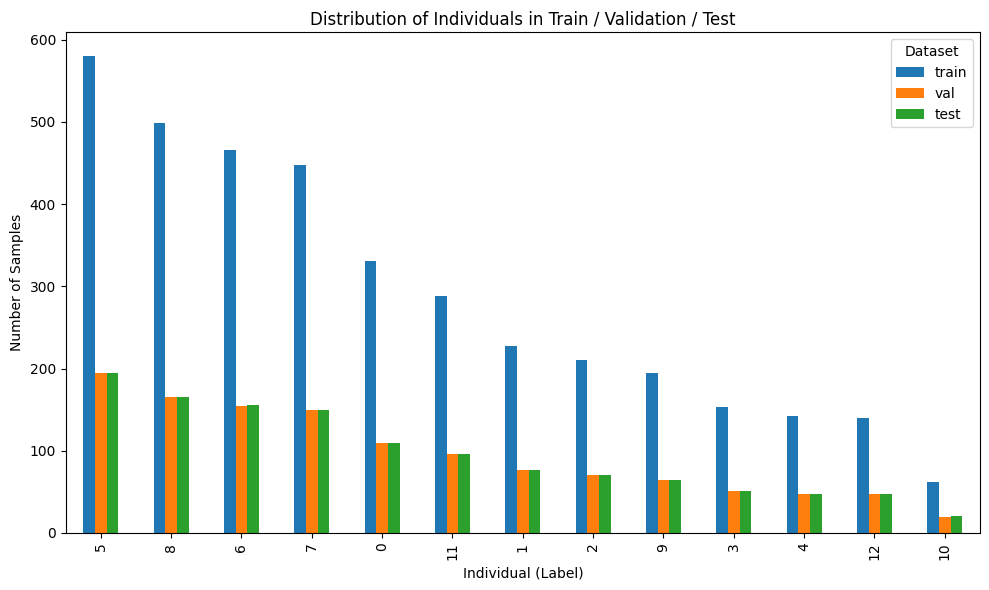

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# --- Count labels in each split ---
def count_labels(dataset):
    """Count label frequencies in a PyTorch dataset."""
    return Counter(label.item() for _, label in dataset)

datasets = {
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
}

# Create DataFrame with counts
counts_df = pd.DataFrame({
    split: pd.Series(count_labels(ds))
    for split, ds in datasets.items()
}).fillna(0).astype(int)

# --- Sort by frequency in train ---
counts_df = counts_df.sort_values(by="train", ascending=False)

# --- Compute totals (not for plotting) ---
total_per_individual = counts_df.sum(axis=1)

# --- Metrics ---
total_vocalizations = int(total_per_individual.sum())
max_vocalizations   = int(total_per_individual.max())
min_vocalizations   = int(total_per_individual.min())
mean_vocalizations  = float(total_per_individual.mean())
std_vocalizations   = float(total_per_individual.std(ddof=1))  # sample SD

# --- Display counts DataFrame ---
display(counts_df)

# --- Print requested metrics ---
print("=== Dataset metrics (all splits combined) ===")
print(f"Total vocalizations: {total_vocalizations}")
print(f"Maximum vocalizations per individual: {max_vocalizations}")
print(f"Minimum vocalizations per individual: {min_vocalizations}")
print(f"Vocalizations per individual (mean ± SD): {mean_vocalizations:.1f} ± {std_vocalizations:.1f}")
print(f"Vocalizations per individual (mean ± SD, rounded): {round(mean_vocalizations):.0f} ± {round(std_vocalizations):.0f}")

# --- Plot per-split distribution ---
counts_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Individual (Label)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Individuals in Train / Validation / Test')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


## Lightning DataModule with Custom Collate (Fixed-length sequences)

In [10]:
from lightning import LightningDataModule
from torch.utils.data import DataLoader
import torch
# import torch.nn as nn
# import os

# --- Collate: pad variable-length sequences and return lengths ---
# def custom_collate_fn(batch):
#     sequences, labels = zip(*batch)  # sequences: [Tensor(n_i, d)], labels: [Tensor(,)]
#     # Make sure types are consistent
#     sequences = [seq.to(dtype=torch.float32) for seq in sequences]
#     labels = torch.stack([lab.to(dtype=torch.long) for lab in labels])

#     lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
#     # Pad to (B, T_max, D); default padding_value=0.0 is explicit here
#     padded_sequences = nn.utils.rnn.pad_sequence(
#         sequences, batch_first=True, padding_value=0.0
#     )
#     return padded_sequences, lengths, labels


class BirdsongDataModule(LightningDataModule):
    def __init__(
        self,
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size: int = 32,
        num_workers: int = 0,              # 0 is safest in notebooks
        pin_memory: bool = False,          # set True if training on GPU
        persistent_workers: bool = False,  # True only if num_workers > 0
        drop_last: bool = False,           # set True if you need fixed batch shapes
    ):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.persistent_workers = persistent_workers if num_workers > 0 else False
        self.drop_last = drop_last

    def _make_loader(self, dataset, shuffle: bool):
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            # collate_fn=custom_collate_fn,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            persistent_workers=self.persistent_workers,
            drop_last=self.drop_last,
        )

    def train_dataloader(self):
        return self._make_loader(self.train_dataset, shuffle=True)

    def val_dataloader(self):
        return self._make_loader(self.val_dataset, shuffle=False)

    def test_dataloader(self):
        return self._make_loader(self.test_dataset, shuffle=False)


# Example instantiation (tweak workers/pin_memory depending on your setup)
use_cuda = torch.cuda.is_available()
data_module = BirdsongDataModule(
    train_dataset,
    val_dataset,
    test_dataset,
    batch_size=32,
    num_workers=0,               # try >0 outside notebooks if IO becomes a bottleneck
    pin_memory=use_cuda,         # helpful when using CUDA
    persistent_workers=False,    # set True only if num_workers > 0
    drop_last=False,
)


## Birdsong Classifier LightningModule FCNN

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from lightning import LightningModule
import torchmetrics
from torchmetrics.classification import F1Score
import logging
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


class BirdsongClassifier(LightningModule):
    """ Fully-connected classifier for fixed-size embedding vectors (B, D).
        Kept a similar API to the LSTM version for minimal changes. """
    def __init__(
        self,
        embedding_dim: int,
        hidden_dim: int,
        num_classes: int,
        lr: float = 1e-3,
        bidirectional: bool = False,
        dropout: float = 0.0,
        use_mean_pool: bool = False,
        class_weights: torch.Tensor | None = None,  # pass on correct device later in setup()
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["class_weights"])
        self.class_weights = class_weights  # store raw; move to device in setup()

        # LSTM
        # self.lstm = nn.LSTM(
        #     input_size=embedding_dim,
        #     hidden_size=hidden_dim,
        #     batch_first=True,
        #     bidirectional=bidirectional,
        #     dropout=dropout if 1 < 1 else 0.0,  # dropout between layers if num_layers>1 (kept 1 layer here)
        # )
        # out_dim = hidden_dim * (2 if bidirectional else 1)

        # self.fc = nn.Sequential(
        #     nn.Dropout(dropout),
        #     nn.Linear(out_dim, num_classes),
        # )

        # Simple MLP: (D) -> (H) -> ReLU -> Dropout -> (num_classes)
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )
        # Metrics (Lightning will aggregate over epoch)
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy   = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy  = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_f1         = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro")
        self.test_f1        = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro")

        # Loss (class weights optional; moved to device in setup())
        self.criterion = nn.CrossEntropyLoss(weight=None)

        # self.use_mean_pool = use_mean_pool

    def setup(self, stage=None):
        # Move class weights to the right device if provided
        if self.class_weights is not None:
            self.criterion = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))

    # --- Utility to support both (x, y) and legacy (x, lengths, y) batches ---
    @staticmethod
    def _unpack_batch(batch):
        if isinstance(batch, (list, tuple)):
            if len(batch) == 2:
                x, y = batch
                return x, y
            elif len(batch) == 3:
                x, _, y = batch   # ignore lengths if present
                return x, y
        raise ValueError("Expected batch as (x, y) or (x, lengths, y)")

    # def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
    #     # x: (B, T, D), lengths: (B,)
    #     packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
    #     packed_out, (h_n, c_n) = self.lstm(packed)

    #     if self.use_mean_pool:
    #         # Mean over valid timesteps (mask-aware)
    #         out, lens = pad_packed_sequence(packed_out, batch_first=True)  # (B, T_max, H[*2])
    #         lens = lens.to(out.device).clamp_min(1).unsqueeze(1)           # (B, 1)
    #         feats = out.sum(dim=1) / lens                                  # (B, H[*2])
    #     else:
    #         # Last hidden state from the top layer
    #         # h_n shape: (num_layers * num_directions, B, H)
    #         feats = h_n[-1]                                                # (B, H[*2] if bidirectional)

    #     logits = self.fc(feats)  # (B, C)
    #     return logits

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, D)
        logits = self.net(x)  # (B, C)
        return logits

    def training_step(self, batch, batch_idx):
       #x, lengths, y = batch
        x, y = self._unpack_batch(batch)
        #logits = self(x, lengths)
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.train_accuracy(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc",  acc,  prog_bar=True)
        logger.info(f"Batch {batch_idx} - Train Loss: {loss.item():.4f} - Train Acc: {acc:.4f}")
        return loss

    def validation_step(self, batch, batch_idx):
        #x, lengths, y = batch
        x, y = self._unpack_batch(batch)
        #logits = self(x, lengths)
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.val_accuracy(logits, y)
        f1  = self.val_f1(logits, y)
        
        # log epoch-level values
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc",  acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_f1",   f1,  prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        # x, lengths, y = batch
        # logits = self(x, lengths)
        x, y = self._unpack_batch(batch)
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.test_accuracy(logits, y)
        f1 = self.test_f1(logits, y)

        # self.test_accuracy.update(logits, y)
        # self.log("test_loss", loss, prog_bar=True)
        # self.log("test_acc",  acc,  prog_bar=True)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc",  acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_f1", f1, prog_bar=True, on_step=False, on_epoch=True)
        logger.info(f"Batch {batch_idx} - Test Loss: {loss.item():.4f} - Test Acc: {acc:.4f}")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [12]:


all_labels = (
    list(id_train_dict.values()) +
    list(id_val_dict.values()) +
    list(id_test_dict.values())
)

model = BirdsongClassifier(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=len(set(all_labels)),  # Adjusted based on label encoder
    lr=LEARNING_RATE
)


## Define Callbacks for Model Checkpointing and Early Stopping

In [13]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

# Save the best model (by val_f1) and also keep the last checkpoint
checkpoint_callback = ModelCheckpoint(
    monitor="val_f1",
    mode="max",
    save_top_k=1,
    save_last=True,
    filename=f"best-{DATASET_NAME}-{SPLIT_TYPE}-FCN-{{epoch:02d}}-{{val_f1:.4f}}",
    # auto_insert_metric_name=False,  # uncomment if you don't want Lightning to append metric names
)

# Early stopping if validation doesn't improve
early_stop_callback = EarlyStopping(
    monitor="val_f1",
    mode="max",
    patience=5,
    min_delta=1e-4,
)


## Trainer configuration with TensorBoard and CSV loggers

In [14]:
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

# TensorBoard + CSV under: logs/<DATASET_NAME>/<SPLIT_TYPE>/<RUN_NAME>/version_x/
tb_logger = TensorBoardLogger(
    save_dir=str(LOG_DIR),   # logs/<DATASET_NAME>/<SPLIT_TYPE>
    name=RUN_NAME,           # <DATASET_NAME>_<SPLIT_TYPE>_RNN
)

csv_logger = CSVLogger(
    save_dir=str(LOG_DIR),   # same root, same run name
    name=RUN_NAME,
)

trainer = Trainer(
    max_epochs=20,
    accelerator="auto",
    devices="auto",
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=[tb_logger, csv_logger],
    log_every_n_steps=10,
    # Reproducibility and stability (safe defaults)
    deterministic=True,        # ensures repeatable results (may be slightly slower)
    #gradient_clip_val=1.0,     # helps stabilize RNN training
    # num_sanity_val_steps=0,  # uncomment if your val metrics require skipping sanity checks
    # precision="16-mixed",    # optional: speed-up on GPU; leave commented to keep numerics identical
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Train the model

In [15]:
trainer.fit(model, datamodule=data_module)


2025-12-17 14:18:57.644371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 14:18:57.653619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765981137.665918   32121 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765981137.670078   32121 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-17 14:18:57.684615: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Plot training and validation metrics from CSV logs

Reading metrics from: /teamspace/studios/this_studio/logs_FCN_birdnet_pooling/chiffchaff/withinyear/chiffchaff_withinyear_FCN/version_1/metrics.csv


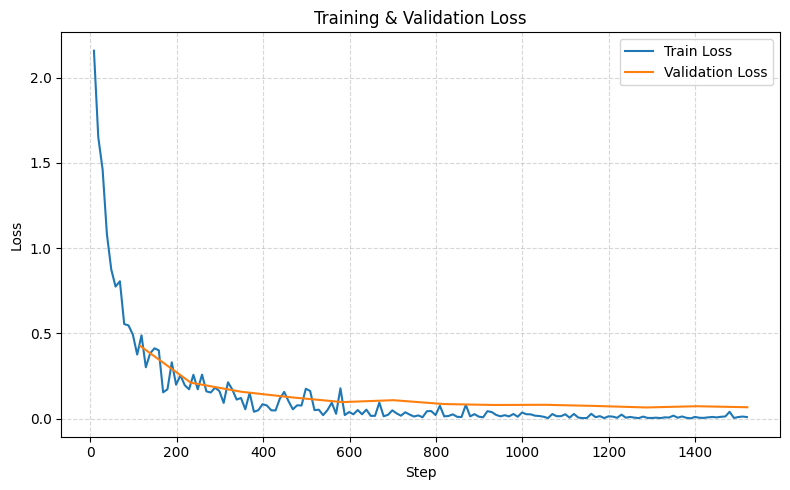

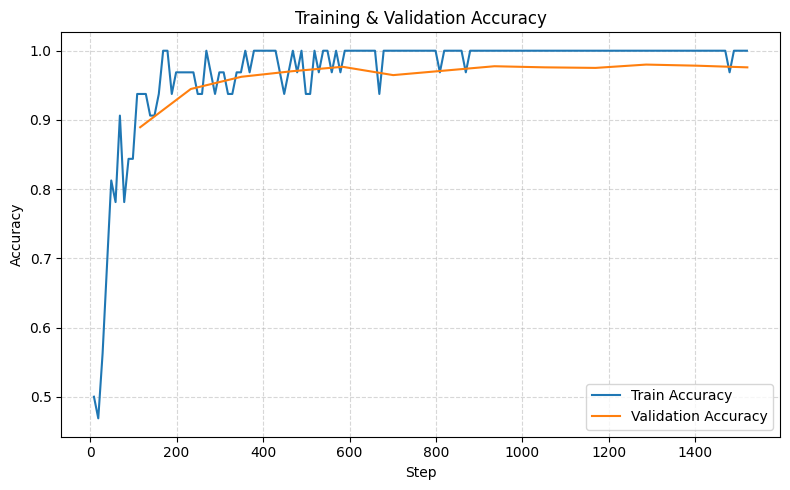

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Find the latest version directory created by the loggers
run_dir = LOG_DIR / RUN_NAME
version_dirs = sorted([p for p in run_dir.glob("version_*") if p.is_dir()],
                      key=lambda p: int(p.name.split("_")[-1]))
if not version_dirs:
    raise FileNotFoundError(f"No version_* folders found under {run_dir}")
latest = version_dirs[-1]
metrics_csv = latest / "metrics.csv"
print("Reading metrics from:", metrics_csv)

df = pd.read_csv(metrics_csv)

# Helper: pick the x-axis. Prefer 'step' if present, else 'epoch' (falls back to index).
x = df["step"] if "step" in df.columns else (df["epoch"] if "epoch" in df.columns else df.index)

# Filter rows that actually contain each metric
df_train_loss = df[df["train_loss"].notna()] if "train_loss" in df.columns else pd.DataFrame()
df_val_loss   = df[df["val_loss"].notna()]   if "val_loss"   in df.columns else pd.DataFrame()
df_train_acc  = df[df["train_acc"].notna()]  if "train_acc"  in df.columns else pd.DataFrame()
df_val_acc    = df[df["val_acc"].notna()]    if "val_acc"    in df.columns else pd.DataFrame()

# ---- Plot 1: Train vs Validation Loss ----
plt.figure(figsize=(8, 5))
if not df_train_loss.empty:
    plt.plot(df_train_loss["step"] if "step" in df_train_loss else df_train_loss.index,
             df_train_loss["train_loss"], label="Train Loss")
if not df_val_loss.empty:
    plt.plot(df_val_loss["step"] if "step" in df_val_loss else df_val_loss.index,
             df_val_loss["val_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ---- Plot 2: Train vs Validation Accuracy ----
plt.figure(figsize=(8, 5))
if not df_train_acc.empty:
    plt.plot(df_train_acc["step"] if "step" in df_train_acc else df_train_acc.index,
             df_train_acc["train_acc"], label="Train Accuracy")
if not df_val_acc.empty:
    plt.plot(df_val_acc["step"] if "step" in df_val_acc else df_val_acc.index,
             df_val_acc["val_acc"], label="Validation Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Test the final (non-checkpoint) model on the test dataset

In [17]:

trainer.test(model, datamodule=data_module)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9775640964508057     │
│          test_f1          │    0.8178384900093079     │
│         test_loss         │    0.06884045153856277    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.06884045153856277,
  'test_acc': 0.9775640964508057,
  'test_f1': 0.8178384900093079}]

## Load the best checkpoint and evaluate it on the test set

In [18]:
# Load the best model (optional)
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

# Alternative: load a specific checkpoint manually
# best_model_path = "KiWi_logs/individual_identification/version_3/checkpoints/best-individual-identification-KiWi.ckpt"

best_model = BirdsongClassifier.load_from_checkpoint(best_model_path)
best_model.eval()
# Evaluate the best model on the test set
results = trainer.test(best_model, datamodule=data_module)

# Print all metrics in a nice format
print("\nTest Metrics:")
for metric, value in results[0].items():
    print(f"{metric}: {value:.4f} ({value*100:.1f}%)" if "acc" in metric or "f1" in metric else f"{metric}: {value:.4f}")

test_acc = results[0]['test_acc']   


Best model saved at: /teamspace/studios/this_studio/logs_FCN_birdnet_pooling/chiffchaff/withinyear/chiffchaff_withinyear_FCN/version_0/checkpoints/best-chiffchaff-withinyear-FCN-epoch=07-val_f1=0.8191.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.973557710647583     │
│          test_f1          │    0.8309912085533142     │
│         test_loss         │    0.0812886655330658     │
└───────────────────────────┴───────────────────────────┘


Test Metrics:
test_loss: 0.0813
test_acc: 0.9736 (97.4%)
test_f1: 0.8310 (83.1%)


## Test set classification report for the best model

In [19]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# Load best checkpoint (if not already loaded)
best_model = BirdsongClassifier.load_from_checkpoint(best_model_path)
best_model.eval()

# Put model on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

all_preds, all_labels = [], []

# Iterate over the test loader
# with torch.no_grad():
#     for x, lengths, y in data_module.test_dataloader():
#         x = x.to(device)
#         lengths = lengths.to(device)
#         y = y.to(device)

#         logits = best_model(x, lengths)
#         preds = torch.argmax(logits, dim=1)

#         all_preds.append(preds.cpu().numpy())
#         all_labels.append(y.cpu().numpy())

with torch.no_grad():
    for x, y in data_module.test_dataloader():  # <-- only (x, y) now
        x = x.to(device)
        y = y.to(device)

        logits = best_model(x)                  # <-- no lengths
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())
        
y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)

# Map class indices -> original string labels from your LabelEncoder
labels = list(range(len(le.classes_)))
target_names = [str(c) for c in le.classes_]

report_text = classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=target_names,
    digits=3,
    zero_division=0,   # avoids warnings if a class has no predicted samples
)

print(report_text)

# Optional: save the report alongside your TensorBoard logs
# (Assumes you set LOG_DIR and RUN_NAME earlier)
out_path = (LOG_DIR / RUN_NAME) / "test_classification_report.txt"
out_path.parent.mkdir(parents=True, exist_ok=True)
with open(out_path, "w") as f:
     f.write(report_text)
print(f"\nSaved classification report to: {out_path}")


              precision    recall  f1-score   support

      PC1101      0.973     1.000     0.987       110
      PC1102      0.962     1.000     0.981        76
      PC1103      1.000     0.900     0.947        70
      PC1104      1.000     0.882     0.938        51
      PC1105      0.915     0.915     0.915        47
      PC1106      0.974     0.985     0.979       194
      PC1107      0.981     1.000     0.990       156
      PC1108      0.961     0.987     0.974       149
      PC1109      1.000     1.000     1.000       166
      PC1110      0.983     0.877     0.927        65
      PC1111      1.000     1.000     1.000        21
      PC1112      0.940     0.979     0.959        96
      PC1113      0.958     0.979     0.968        47

    accuracy                          0.974      1248
   macro avg      0.973     0.962     0.967      1248
weighted avg      0.974     0.974     0.973      1248


Saved classification report to: /teamspace/studios/this_studio/logs_FCN_birdne

## Model evaluation function with metrics and ROC AUC

In [20]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    f1_score, recall_score, balanced_accuracy_score, accuracy_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import numpy as np
import torch
import matplotlib.pyplot as plt

def evaluate_split(model, loader, le, split_name: str):
    """Evaluate a model on a dataloader and compute multiple metrics."""
    model.eval()
    device = next(model.parameters()).device

    all_preds, all_labels, all_logits = [], [], []

    # with torch.no_grad():
    #     for x, lengths, y in loader:
    #         x = x.to(device)
    #         lengths = lengths.to(device)
    #         y = y.to(device)

    #         logits = model(x, lengths)
    #         preds = torch.argmax(logits, dim=1)

    #         all_logits.append(logits.cpu().numpy())
    #         all_preds.append(preds.cpu().numpy())
    #         all_labels.append(y.cpu().numpy())

    with torch.no_grad():
        for x, y in loader:                         # CHANGED: (x, y)
            x = x.to(device)
            y = y.to(device)

            logits = model(x)                       # CHANGED: model(x)
            preds = torch.argmax(logits, dim=1)

            all_logits.append(logits.detach().cpu().numpy())
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(y.detach().cpu().numpy())

    # Arrays
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    logits_np = np.concatenate(all_logits, axis=0)

    # Confusion matrix (plot)
    labels = list(range(len(le.classes_)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_).plot(
        ax=ax, xticks_rotation=45, cmap="Blues", colorbar=True
    )
    ax.set_title(f"Confusion Matrix — {split_name}")
    plt.tight_layout()
    plt.show()

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    acc_bal = balanced_accuracy_score(y_true, y_pred)
    recall_macro    = recall_score(y_true, y_pred, labels=labels, average="macro",    zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, labels=labels, average="weighted", zero_division=0)
    f1_macro        = f1_score(y_true, y_pred,     labels=labels, average="macro",    zero_division=0)
    f1_weighted     = f1_score(y_true, y_pred,     labels=labels, average="weighted", zero_division=0)

    # ROC AUC (macro)
    num_classes = len(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    probs = torch.softmax(torch.tensor(logits_np), dim=1).numpy()
    roc_auc_macro = roc_auc_score(y_true_bin, probs, average="macro", multi_class="ovr")

    # Print and return
    print(f"{split_name} — Accuracy:          {acc:.4f} ({acc*100:.1f}%)")
    print(f"{split_name} — Balanced accuracy: {acc_bal:.4f} ({acc_bal*100:.1f}%)")
    print(f"{split_name} — Recall (macro):    {recall_macro:.4f}")
    print(f"{split_name} — Recall (weighted): {recall_weighted:.4f}")
    print(f"{split_name} — F1 (macro):        {f1_macro:.4f} ({f1_macro*100:.1f}%)")
    print(f"{split_name} — F1 (weighted):     {f1_weighted:.4f}")
    print(f"{split_name} — ROC AUC (macro):   {roc_auc_macro:.4f}\n")

    return {
        "accuracy": acc,
        "balanced_accuracy": acc_bal,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "roc_auc_macro": roc_auc_macro,
    }



## Evaluate best model on Validation and Test sets, then plot Test metrics as a bubble chart

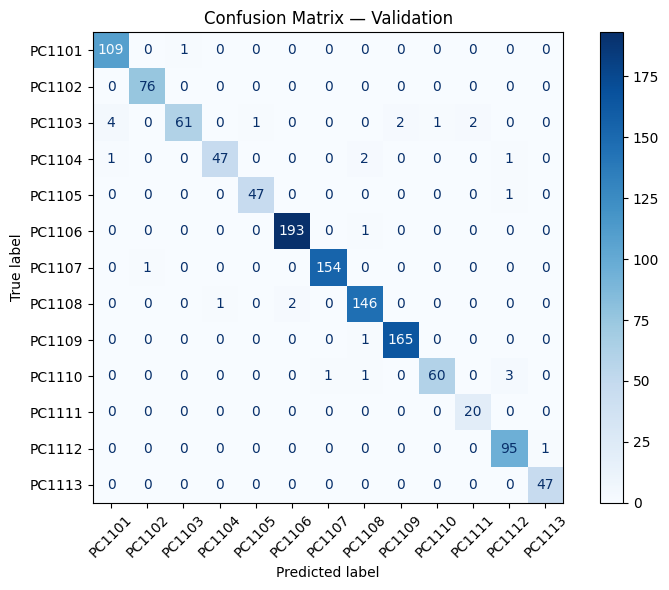

Validation — Accuracy:          0.9776 (97.8%)
Validation — Balanced accuracy: 0.9712 (97.1%)
Validation — Recall (macro):    0.9712
Validation — Recall (weighted): 0.9776
Validation — F1 (macro):        0.9713 (97.1%)
Validation — F1 (weighted):     0.9773
Validation — ROC AUC (macro):   0.9997



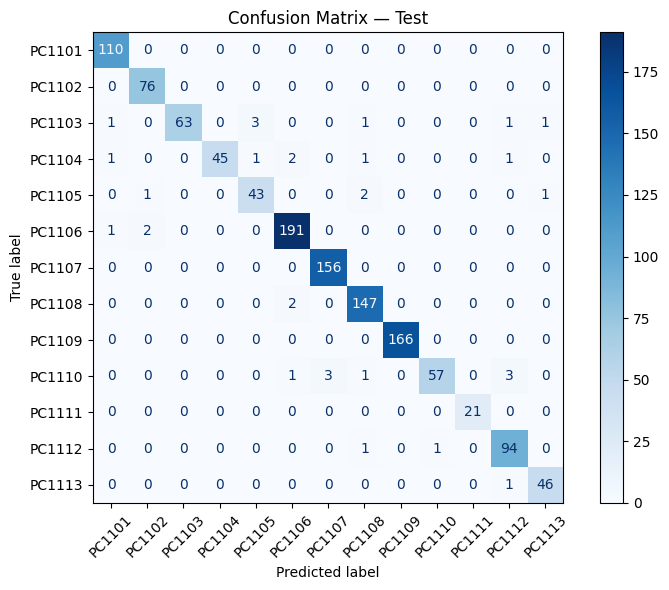

Test — Accuracy:          0.9736 (97.4%)
Test — Balanced accuracy: 0.9618 (96.2%)
Test — Recall (macro):    0.9618
Test — Recall (weighted): 0.9736
Test — F1 (macro):        0.9665 (96.7%)
Test — F1 (weighted):     0.9732
Test — ROC AUC (macro):   0.9996



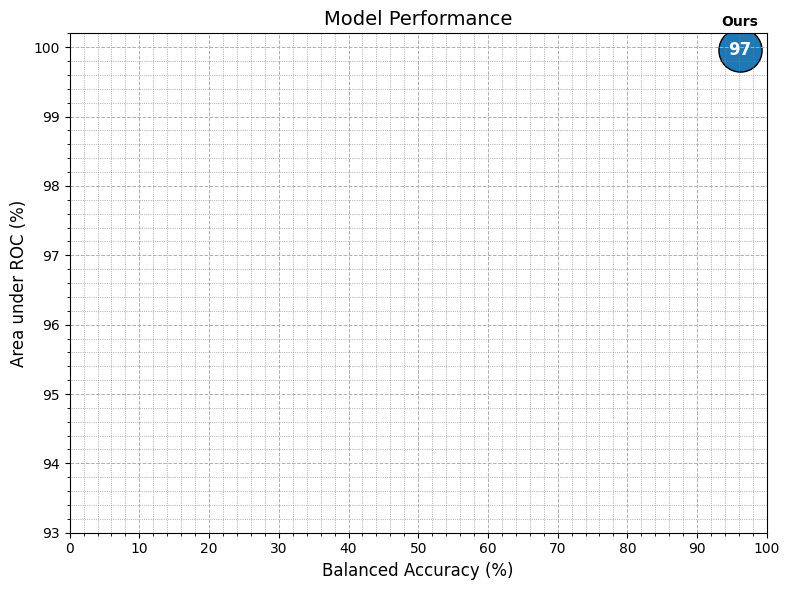

In [21]:
# Ensure the model is on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

# Evaluate and collect metrics
val_metrics  = evaluate_split(best_model, data_module.val_dataloader(),  le, "Validation")
test_metrics = evaluate_split(best_model, data_module.test_dataloader(), le, "Test")

# --- Bubble plot from TEST metrics ---
import matplotlib.pyplot as plt
import numpy as np

# Metrics for the figure
balanced_accuracy = test_metrics["balanced_accuracy"] * 100   # Balanced Accuracy (%)
roc_auc = test_metrics["roc_auc_macro"] * 100            # Area under ROC (%)
f1_macro = test_metrics["f1_macro"]                       # 0..1
model_name = "Ours"

# Figure
fig, ax = plt.subplots(figsize=(8, 6))

# Bubble size proportional to F1 (tune the factor if needed)
bubble_size = 1000 * f1_macro

# Scatter
ax.scatter(balanced_accuracy, roc_auc, s=bubble_size, edgecolors='black', alpha=1)

# Text inside bubble: F1 in percent, rounded
ax.text(balanced_accuracy, roc_auc, f"{int(round(f1_macro*100))}",
        fontsize=12, ha='center', va='center', color='white', fontweight='bold')

# Model name above bubble
ax.text(balanced_accuracy, roc_auc + 0.3, model_name,
        fontsize=10, ha='center', va='bottom', color='black', fontweight='bold')

# Axes customization (adjust if your ranges differ)
ax.set_xlim(0, 100)
ax.set_ylim(93, 100.2)

ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks(np.arange(93, 100.2, 1))
ax.set_xticks(np.arange(0, 101, 2), minor=True)
ax.set_yticks(np.arange(93, 100.2, 0.2), minor=True)

ax.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')
ax.grid(True, which='major', linestyle='--', linewidth=0.7)

ax.set_xlabel("Balanced Accuracy (%)", fontsize=12)
ax.set_ylabel("Area under ROC (%)", fontsize=12)
ax.set_title("Model Performance", fontsize=14)

plt.tight_layout()
plt.savefig("LSTM_AudioID_performance.png", dpi=300)
plt.show()
